In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


file_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
data = pd.read_csv(file_path)

df = data.copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']
y_binary = np.where(y == 'BENIGN', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.15, random_state=42, stratify=y_binary
)

top6_features_path = open('models/top6_features.txt', 'r')
top6_features = [line.strip() for line in top6_features_path.readlines()]
top6_features_path.close()
print("## Top 6 Features:")
for feature in top6_features:
    print(f" - {feature}")

best_features_path = open('models/best_features.txt', 'r')
best_features = [line.strip() for line in best_features_path.readlines()]
best_features_path.close()
print("## Best Features:")
for feature in best_features:
    print(f" - {feature}")

X_train_top6 = X_train[top6_features]
X_test_top6 = X_test[top6_features]

X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


## Top 6 Features:
 - Avg_Bwd_Segment_Size
 - Max_Packet_Length
 - Bwd_Packet_Length_Max
 - Packet_Length_Std
 - Average_Packet_Size
 - Destination_Port
## Best Features:
 - Destination_Port
 - Total_Backward_Packets
 - Fwd_Packet_Length_Mean
 - Bwd_Packet_Length_Max
 - Bwd_Packet_Length_Mean
 - Bwd_Packet_Length_Std
 - Flow_Bytes_s
 - Flow_IAT_Mean
 - Fwd_IAT_Max
 - Fwd_Header_Length
 - Bwd_Header_Length
 - Bwd_Packets_s
 - Max_Packet_Length
 - Packet_Length_Mean
 - Packet_Length_Std
 - Packet_Length_Variance
 - Average_Packet_Size
 - Avg_Fwd_Segment_Size
 - Avg_Bwd_Segment_Size
 - Subflow_Bwd_Packets
 - Init_Win_bytes_forward
 - Init_Win_bytes_backward


In [2]:
print("## 모델 불러오기")

import joblib
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import h5py

def create_lstm_model(lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

rf_full_path = os.path.abspath('models/rf_model_full.pkl')
rf_top6_path = os.path.abspath('models/rf_model_top6.pkl')
rf_best_path = os.path.abspath('models/rf_model_best.pkl')
lstm_path = os.path.abspath('models/lstm_model.h5')

rf_full_model = joblib.load(rf_full_path)
rf_top6_model = joblib.load(rf_top6_path)
rf_best_model = joblib.load(rf_best_path)

with h5py.File(lstm_path, 'r') as f:
    lstm_model = load_model(f)

## 모델 불러오기



3248/3248 [==============================] - 3s 952us/step


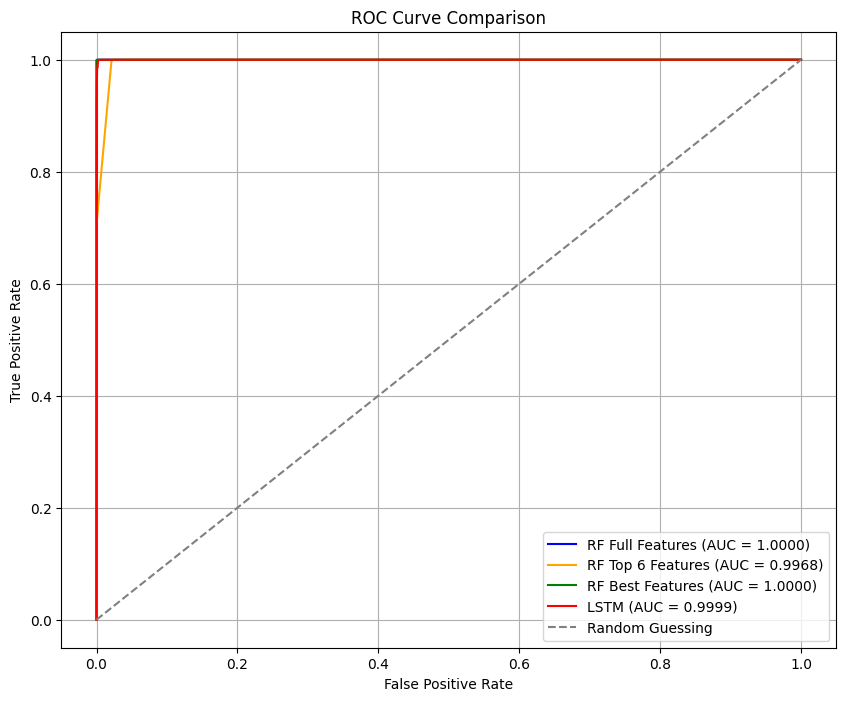

In [3]:
## ROC 곡선 시각화
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_rf_full = rf_full_model.predict_proba(X_test)[:, 1]
y_pred_rf_top6 = rf_top6_model.predict_proba(X_test_top6)[:, 1]
y_pred_rf_best = rf_best_model.predict_proba(X_test_best)[:, 1]
y_pred_lstm = lstm_model.predict(X_test_lstm).ravel()

fpr_rf_full, tpr_rf_full, _ = roc_curve(y_test, y_pred_rf_full)
fpr_rf_top6, tpr_rf_top6, _ = roc_curve(y_test, y_pred_rf_top6)
fpr_rf_best, tpr_rf_best, _ = roc_curve(y_test, y_pred_rf_best)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)

roc_auc_rf_full = auc(fpr_rf_full, tpr_rf_full)
roc_auc_rf_top6 = auc(fpr_rf_top6, tpr_rf_top6)
roc_auc_rf_best = auc(fpr_rf_best, tpr_rf_best)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf_full, tpr_rf_full, color='blue', label=f'RF Full Features (AUC = {roc_auc_rf_full:.4f})')
plt.plot(fpr_rf_top6, tpr_rf_top6, color='orange', label=f'RF Top 6 Features (AUC = {roc_auc_rf_top6:.4f})')
plt.plot(fpr_rf_best, tpr_rf_best, color='green', label=f'RF Best Features (AUC = {roc_auc_rf_best:.4f})')
plt.plot(fpr_lstm, tpr_lstm, color='red', label=f'LSTM (AUC = {roc_auc_lstm:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.savefig('roc_curve_comparison.png')

plt.show()